# Importações

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import shap
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.ensemble import RandomForestRegressor as RF

import pandas as pd
import seaborn as sns

SEED = 100


def reset_seed(rnd_seed=SEED):
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(rnd_seed)

reset_seed()


/home/eduardo/miniconda3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carregar Datasets

In [2]:
df_mesclado = pd.read_csv("./dados/dados_mesclados.csv", sep=';', decimal='.')

dataframes = []
dataframes_treino = []

for campus, dados in df_mesclado.groupby("CAMPUS"):
    dados["CAMPUS"] = campus
    for i in range(1, 12 + 1):
        lag = dados['CONSUMO'].shift(i)
        dados[f'LAG_' + '{:02d}'.format(i)] = lag
    dados.dropna(inplace=True)
   
    treino, teste = train_test_split(dados, test_size=12, random_state=SEED, shuffle=False)

    dataframes.append(dados)
    dataframes_treino.append(treino)

df = pd.concat(dataframes, ignore_index=True)
df_treino = pd.concat(dataframes_treino, ignore_index=True).sort_values("CAMPUS").sort_values("DATA")

df_treino

,CONSUMO,DATA,TEMP_MIN_MÉD_MENS,TEMP_MÉD_MIN_MENS,TEMP_MÉD_MÉD_MENS,TEMP_MÉD_MAX_MENS,TEMP_MÉD_ACC_MENS,TEMP_MAX_MÉD_MENS,PRECIPITAÇÃO_MÉD_MENS,TEMP_MIN_MIN_MENS,...,LAG_03,LAG_04,LAG_05,LAG_06,LAG_07,LAG_08,LAG_09,LAG_10,LAG_11,LAG_12
1269,20538.0,2015-01-31,19.0,22.0,26.0,30.0,813.0,36.0,9.0,19.0,...,28512.0,25197.0,23689.0,19233.0,22072.0,27300.0,28019.0,35073.0,32533.0,22379.0
1270,30308.0,2015-02-28,19.0,21.0,25.0,29.0,702.0,35.0,13.0,19.0,...,32587.0,28512.0,25197.0,23689.0,19233.0,22072.0,27300.0,28019.0,35073.0,32533.0
1375,14467.0,2015-02-28,20.0,23.0,26.0,28.0,730.0,33.0,6.0,20.0,...,17594.0,15075.0,14127.0,12979.0,10603.0,9687.0,11843.0,13521.0,14460.0,15096.0
1271,39407.0,2015-03-31,18.0,21.0,24.0,26.0,738.0,30.0,6.0,18.0,...,27349.0,32587.0,28512.0,25197.0,23689.0,19233.0,22072.0,27300.0,28019.0,35073.0
1376,21303.0,2015-03-31,18.0,23.0,25.0,27.0,786.0,33.0,2.0,18.0,...,14740.0,17594.0,15075.0,14127.0,12979.0,10603.0,9687.0,11843.0,13521.0,14460.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1743,20136.0,2023-10-31,13.0,17.0,22.0,27.0,674.0,33.0,15.0,13.0,...,13316.0,16272.0,17843.0,17705.0,23262.0,13828.0,11147.0,14541.0,15051.0,15608.0
166,6572.0,2023-10-31,17.0,21.0,26.0,31.0,798.0,36.0,11.0,17.0,...,3299.0,4485.0,4914.0,5011.0,7288.0,5110.0,2769.0,3592.0,4141.0,4200.0
1561,5793.0,2023-10-31,11.0,12.0,19.0,24.0,584.0,32.0,14.0,11.0,...,4780.0,6372.0,6360.0,5665.0,6640.0,5197.0,3850.0,4789.0,5935.0,6280.0
1622,5076.0,2023-10-31,13.0,18.0,22.0,26.0,685.0,33.0,19.0,13.0,...,3803.0,6064.0,5033.0,3774.0,5940.0,4521.0,3255.0,4584.0,4607.0,4502.0


# Estatísticas dos Dados

In [3]:
summary = df_mesclado[df_mesclado["CONSUMO"] > 0].groupby('CAMPUS').agg(
    Data_Inicial=('DATA', 'min'),
    Data_Final=('DATA', 'max'),
    Numero_de_Dados=('CONSUMO', 'count'),
    Media=('CONSUMO', 'mean'),
    Mediana=('CONSUMO', 'median'),
    Desvio_Padrao=('CONSUMO', 'std'),
    Maximo=('CONSUMO', 'max'),
    Minimo=('CONSUMO', 'min'),
).reset_index()

summary['Periodo'] = pd.to_datetime(summary['Data_Inicial']).dt.strftime('%m/%Y') + ' à ' + pd.to_datetime(
    summary['Data_Final']).dt.strftime('%m/%Y')
summary = summary.drop(["Data_Inicial", "Data_Final"], axis=1)

summary.to_csv("./dados/estatisticas.csv", index=False, sep=";", decimal=".")

summary


,CAMPUS,Numero_de_Dados,Media,Mediana,Desvio_Padrao,Maximo,Minimo,Periodo
0,ARAPONGAS,25,192.280000,164.0,113.166367,473.0,34.0,10/2022 à 10/2024
1,ASSIS CHATEAUBRIAND,117,10227.205128,9732.0,4524.737103,21548.0,1159.0,02/2015 à 10/2024
2,ASTORGA,86,4029.116279,4229.5,1698.610390,8741.0,1473.0,09/2017 à 10/2024
3,BARRACÃO,115,2613.495652,2514.0,923.623588,7246.0,904.0,04/2015 à 10/2024
4,CAMPO LARGO,117,7731.991453,8368.0,3101.675494,12624.0,2504.0,02/2015 à 10/2024
5,CAPANEMA,85,5042.388235,5222.0,2667.461131,14401.0,702.0,10/2017 à 10/2024
6,CASCAVEL,86,9533.360465,9654.5,3423.116554,19502.0,4188.0,09/2017 à 10/2024
7,COLOMBO,67,3876.701493,3732.0,1833.118712,7589.0,1498.0,04/2019 à 10/2024
8,CORONEL VIVIDA,87,2322.609195,2207.0,704.116011,4826.0,1107.0,08/2017 à 10/2024
9,CURITIBA,75,21410.026667,18782.0,9389.156519,42043.0,7432.0,08/2018 à 10/2024


# Séries Temporais

In [4]:

def formater_thousands(x, pos):
    return f'{int(x):,}'


for reg, df_reg in df_mesclado[df_mesclado["CONSUMO"] > 0].groupby("REGIÃO"):
    plt.figure(figsize=(18, 5))
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(
        color=["red", "darkgoldenrod", "blue", "green", "purple", "slategrey", "coral"])

    for campus, dados in df_reg.groupby("CAMPUS"):
        dados["DATA"] = pd.to_datetime(dados['DATA'])
        dados.set_index("DATA", inplace=True)
        plt.plot(dados["CONSUMO"], label=f"IFPR - CAMPUS {campus}")

    plt.xlabel('Anos')
    plt.ylabel('Consumo (KWh)')

    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(formater_thousands))
    ax.set_facecolor('white')
    plt.grid(True, color='grey', linestyle="--", linewidth=0.75)
    plt.legend(facecolor='white', framealpha=0.5)
    plt.savefig(f"./dados/series/{reg}.png", bbox_inches='tight')
    plt.close()


# Autocorrelação

In [5]:

for campus, dados in df_mesclado[df_mesclado["CONSUMO"] > 0].groupby("CAMPUS"):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_facecolor('white')
    plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

    plot_acf(dados["CONSUMO"], ax=ax, lags=12)
    plt.savefig(f"./dados/autocorrelação/ACF-{campus}.png", bbox_inches='tight')
    plt.close()


# Autocorrelação Parcial

In [6]:
for campus, dados in df_mesclado[df_mesclado["CONSUMO"] > 0].groupby("CAMPUS"):
    plt.rcParams['xtick.labelsize'] = 15
    plt.rcParams['ytick.labelsize'] = 15
    plt.rcParams.update({'font.size': 15})
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["blue"])

    fig, ax = plt.subplots(figsize=(6, 3))
    ax.set_facecolor('white')
    plt.grid(True, color='grey', linestyle="--", linewidth=0.75)

    plot_pacf(dados["CONSUMO"], ax=ax, lags=12)
    plt.savefig(f"./dados/autocorrelação/PACF-{campus}.png", bbox_inches='tight')
    plt.close()


# Testes de Hipoteses

In [7]:
#TODO

# Correlação

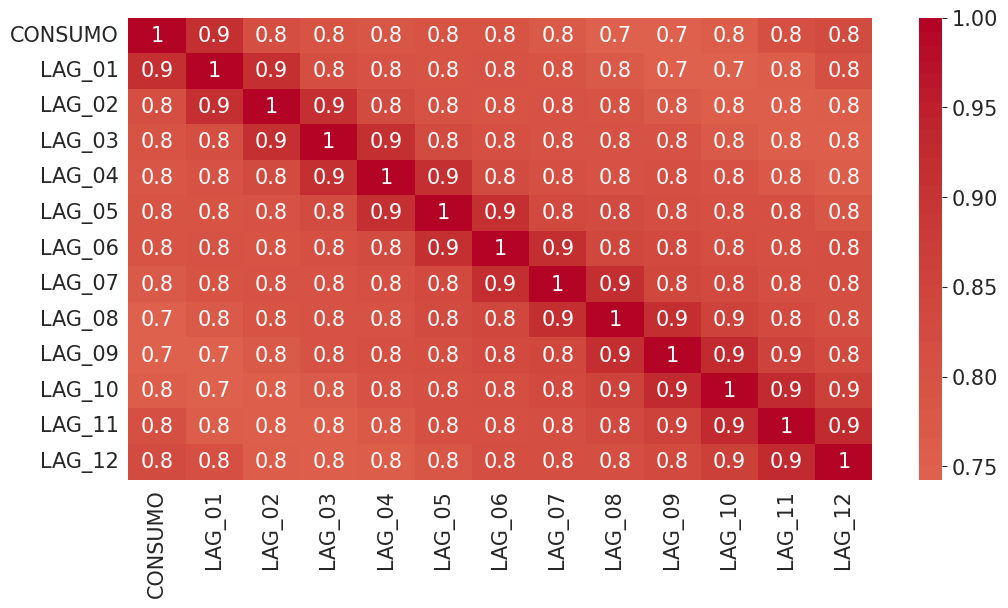

In [8]:
columns = df.filter(like="LAG_").columns.tolist()
columns.insert(0, "CONSUMO")

corr_matrix = df[columns].dropna().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

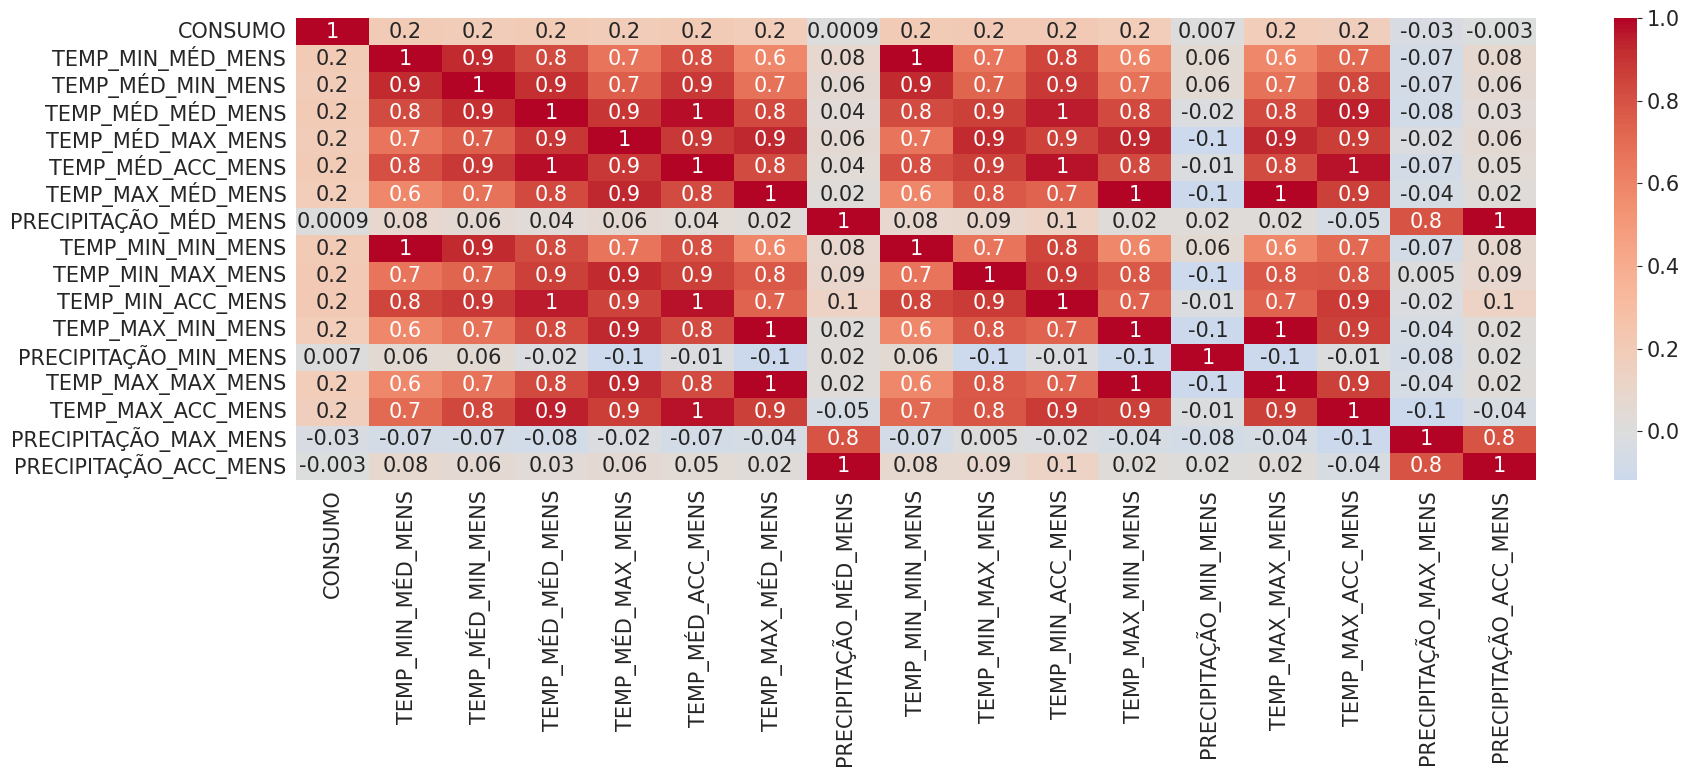

In [9]:
columns = df.filter(like="_MENS").columns.tolist()
columns.insert(0, "CONSUMO")

corr_matrix = df[columns].dropna().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

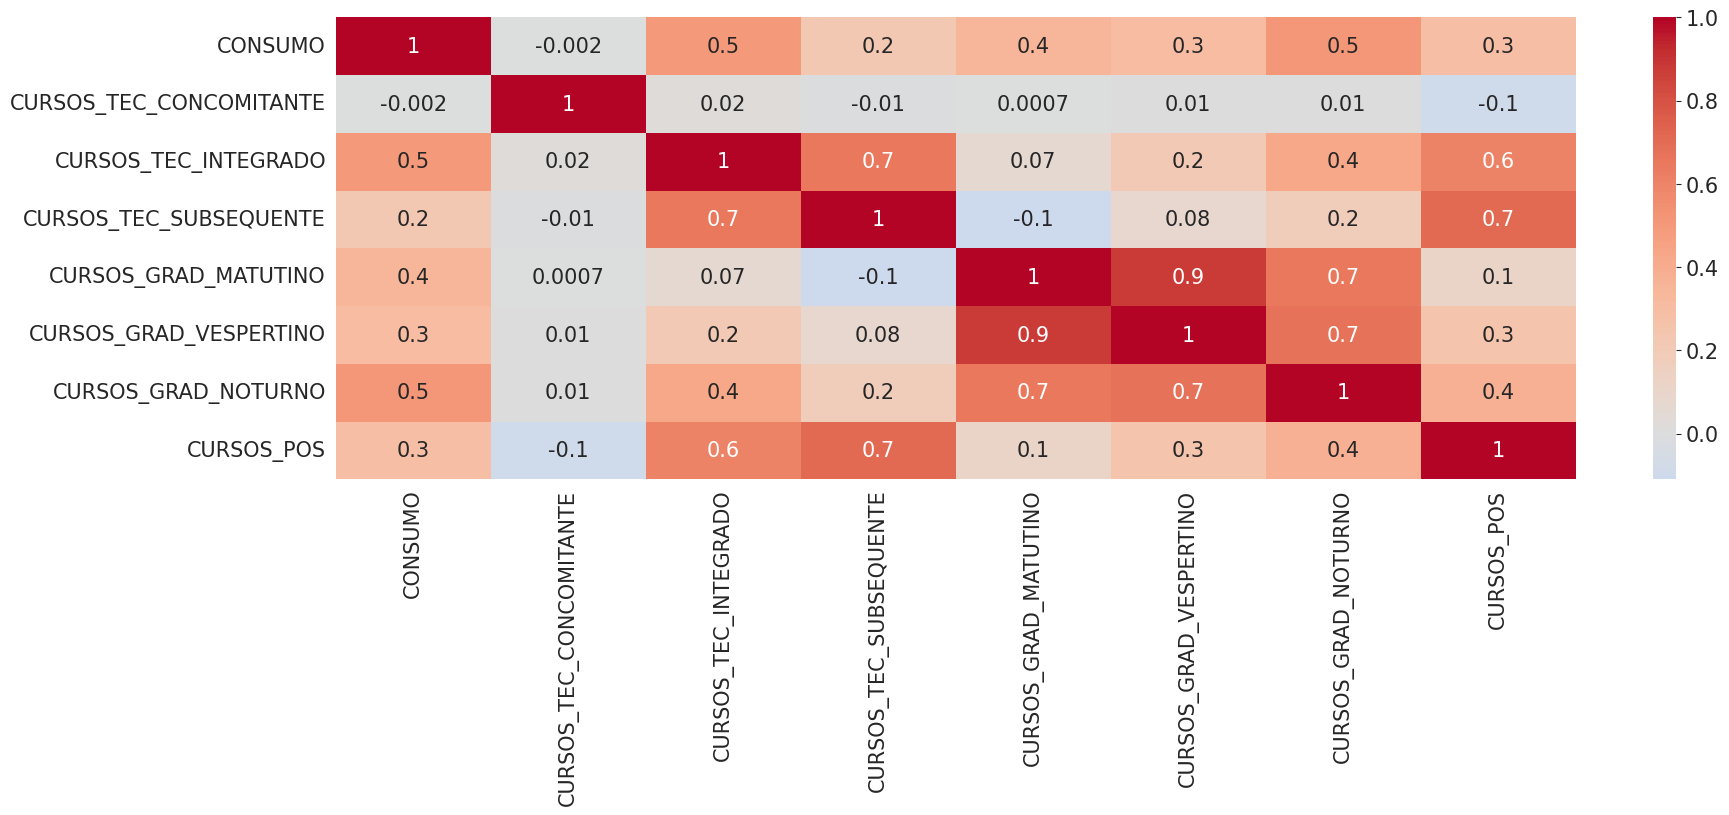

In [10]:
columns = df.filter(like="CURSOS").columns.tolist()
columns.insert(0, "CONSUMO")

corr_matrix = df[columns].dropna().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

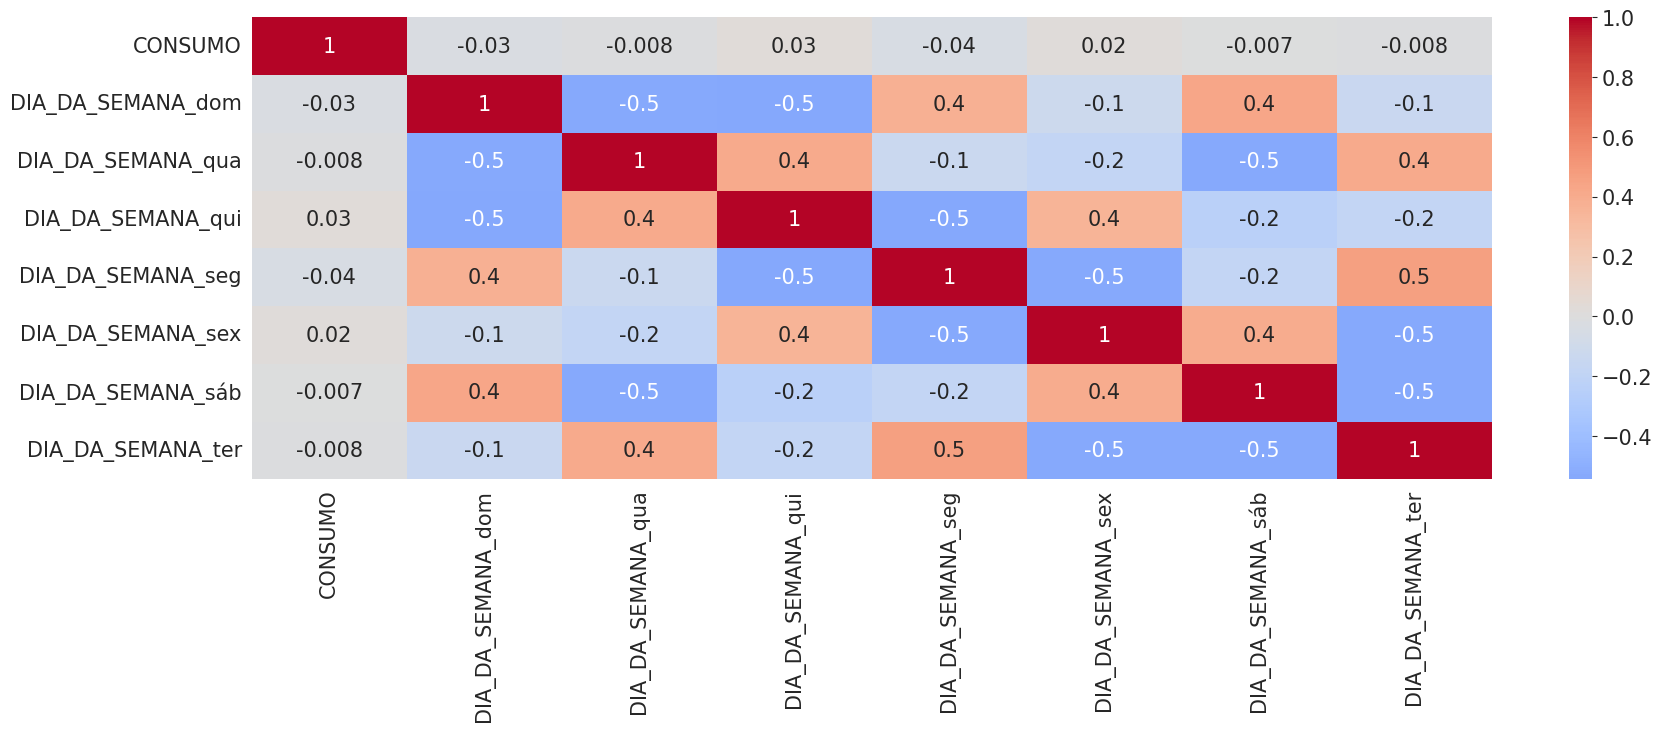

In [11]:
columns = df.filter(like="DIA_").columns.tolist()
columns.insert(0, "CONSUMO")

corr_matrix = df[columns].dropna().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

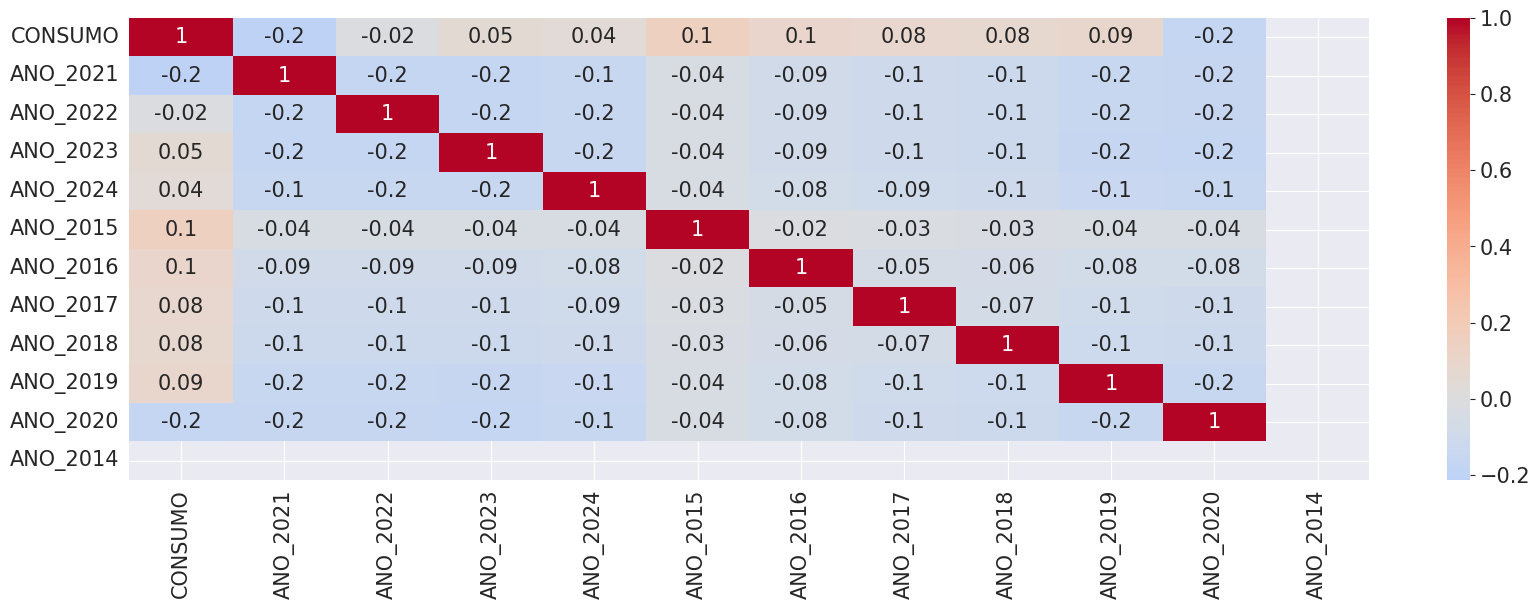

In [12]:
columns = df.filter(like="ANO_").columns.tolist()
columns.insert(0, "CONSUMO")

corr_matrix = df[columns].dropna().corr(
    numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(corr_matrix,
            cmap="coolwarm",
            center=0,
            annot=True,
            fmt='.1g',
            ax=ax)
plt.show()

# Importância das Features

In [ ]:
x = df_treino.drop(["CONSUMO", "DATA", "CAMPUS", "REGIÃO"], axis=1)
y = df_treino["CONSUMO"]

rf = RF(random_state=SEED)

rf.fit(x, y)

shap.initjs()

explainer_rf = shap.explainers.TreeExplainer(rf)

shap_rf = explainer_rf(x)
importancia = pd.DataFrame(list(zip(x.columns, np.abs(shap_rf.values).mean(0))), columns=["FEATURE", "IMPORTÂNCIA"])
importancia = importancia.sort_values(by=["IMPORTÂNCIA"], ascending=False)
importancia["IMPORTÂNCIA"] = importancia["IMPORTÂNCIA"].round(2)

importancia.to_csv("./dados/importancia.csv", index=False, sep=";", decimal=".")

importancia


# Seleção de Features

In [ ]:
importancia = pd.read_csv("./dados/importancia.csv", sep=";", decimal=".", header=0)

features_selecionadas = (importancia[:10]["FEATURE"].tolist()  
                         + df_treino.filter(like="ANO_").columns.tolist()
                         + df_treino.filter(like="MES_").columns.tolist()
                         + df_treino.filter(like="CAMPUS_").columns.tolist())

importancia.set_index("FEATURE", inplace=True)

features_selecao = importancia.drop(features_selecionadas, axis=0).reset_index()

features_selecao['PROBABILIDADE'] = features_selecao['IMPORTÂNCIA'] / features_selecao['IMPORTÂNCIA'].sum()

fitness_agrupado = {}
fitness_individual = {}

reset_seed()
for i in range(1, 100):
    rf = RF(random_state=SEED)
    num_features = np.random.randint(1, len(features_selecao))
    opt_features = np.random.choice(features_selecao['FEATURE'], size=num_features, replace=False,
                                    p=features_selecao['PROBABILIDADE']).tolist()
    opt_features = features_selecionadas + opt_features
    
    cvs_agrupado = []
    subdf = {data: dados for data, dados in df_treino.sort_values("CAMPUS", ascending=True).groupby('DATA')}
    for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(subdf):
        i_treino = [list(subdf.keys())[index] for index in i_treino]  
        i_teste = [list(subdf.keys())[index] for index in i_teste]

        dados_treino = pd.concat([subdf[index] for index in i_treino], ignore_index=True)
        dados_teste = pd.concat([subdf[index] for index in i_teste], ignore_index=True)
        
        x_treino, y_treino = dados_treino[opt_features].astype(np.float32), dados_treino["CONSUMO"].astype(np.float32)
        x_teste, y_teste = dados_teste[opt_features], dados_teste["CONSUMO"]
        
        rf.fit(x_treino, y_treino)
        
        y_previsto = []
        for index, row in x_teste.iterrows():
            previsao = rf.predict(pd.DataFrame(row).transpose())
            y_previsto.append(previsao)
        mape = mean_absolute_percentage_error(y_teste, y_previsto)
        cvs_agrupado.append(mape)
    
    cvs_individual = []
    for campus, dados in df_treino.sort_values("DATA").groupby("CAMPUS"):
        for i_treino, i_teste in TimeSeriesSplit(n_splits=5, test_size=1).split(dados):
            x_treino, y_treino = dados[opt_features].iloc[i_treino].astype(np.float32), dados["CONSUMO"].iloc[i_treino].astype(np.float32)
            x_teste, y_teste = dados[opt_features].iloc[i_teste], dados["CONSUMO"].iloc[i_teste]
            
            rf.fit(x_treino, y_treino)
            
            y_previsto = rf.predict(x_teste)
            mape = mean_absolute_percentage_error(y_teste, y_previsto)
            cvs_individual.append(mape)
            
    fitness_agrupado[tuple(opt_features)] = np.array(cvs_agrupado).mean()
    fitness_individual[tuple(opt_features)] = np.array(cvs_individual).mean()
    
fitness_agrupado = pd.DataFrame(list(fitness_agrupado.items()), columns=["FEATURES", "MAPE"])
fitness_individual = pd.DataFrame(list(fitness_individual.items()), columns=["FEATURES", "MAPE"])

fitness_agrupado.to_csv("./dados/fitness_features_agrupado.csv", index=False, sep=";", decimal=".")
fitness_individual.to_csv("./dados/fitness_features_individual.csv", index=False, sep=";", decimal=".")

In [4]:
fitness_agrupado = pd.read_csv("./dados/fitness_features_agrupado.csv", sep=";", decimal=".")

fitness_agrupado = fitness_agrupado.sort_values("MAPE").head(1).reset_index(drop=True)
fitness_agrupado = pd.DataFrame(str(fitness_agrupado.iloc[0]["FEATURES"]).replace("(",'').replace(")",'').replace("'", "").split(", "), columns=["FEATURES"])

fitness_agrupado

,FEATURES
0,LAG_01
1,LAG_12
2,LAG_06
3,LAG_05
4,LAG_11
...,...
65,CURSOS_GRAD_VESPERTINO
66,FERIADO
67,DIA_DA_SEMANA_sex
68,CURSOS_TEC_INTEGRADO


In [5]:
fitness_individual = pd.read_csv("./dados/fitness_features_individual.csv", sep=";", decimal=".")

fitness_individual = fitness_individual.sort_values("MAPE").head(1).reset_index(drop=True)
fitness_individual = pd.DataFrame(str(fitness_individual.iloc[0]["FEATURES"]).replace("(",'').replace(")",'').replace("'", "").split(", "), columns=["FEATURES"])

fitness_individual

,FEATURES
0,LAG_01
1,LAG_12
2,LAG_06
3,LAG_05
4,LAG_11
...,...
68,DIA_DA_SEMANA_qua
69,MÊS_ago
70,CURSOS_GRAD_VESPERTINO
71,TEMP_MAX_ACC_MENS
